### Build a Basic ChatBot with LangGraph(with GraphAPI)

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [4]:
class State(TypedDict):
    # Messages have the type list the add_message function in the annotation 
    # defines how this state key should be updated
    # in this case it appends message to the list rather than overwriting it
    messages:Annotated[list, add_messages]



In [5]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_deepseek import ChatDeepSeek

llm =  ChatDeepSeek(model="deepseek-chat", api_key=os.getenv('DEEPSEEK_API_KEY_1'), base_url="https://api.deepseek.com", max_retries=2)

In [7]:
## Node Functionality
def chatbot(state:State):
    return {"messages": [llm.invoke(state['messages'])]}

In [8]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot", chatbot)
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

## Compile the graph
graph = graph_builder.compile()

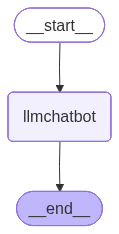

In [9]:
## Visualize the graph 
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response = graph.invoke({'messages': 'Hi (en)'})

In [11]:
response['messages'][-1].content

'Hello! How can I assist you today? 😊'

In [12]:
for event in graph.stream({"messages":"Hi how are you doing today (en)"}):
    for value in event.values():
        print(value['messages'][-1])

content="Hello! I'm doing well, thank you for asking. 😊\n\nHow are you today? Is there anything I can help you with?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 13}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '9fcc88c1-f0d0-4e52-bce0-c92eabd82edb', 'finish_reason': 'stop', 'logprobs': None} id='lc_run--019b2d8f-2dd2-7783-9aad-f2d6438261dc-0' usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}


### ChatBot With Tool

In [13]:
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = os.getenv('TAVILY_API_KEY')
tool = TavilySearch(max_results=2)
tool.invoke("What does CAG actually mean in llm?")

c:\Users\ritik\PycharmProjects\trialProject\AgenticAI\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
c:\Users\ritik\PycharmProjects\trialProject\AgenticAI\.venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


{'query': 'What does CAG actually mean in llm?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.lumenova.ai/blog/cag-what-is-cache-augumented-generation/',
   'title': 'CAG: What Is Cache-Augmented Generation and How to Use It',
   'content': 'CAG is an innovative approach that enhances the efficiency of LLMs by preloading all pertinent information into the model’s context, thereby eliminating the need for real-time data retrieval. CAG does the same for AI by preloading relevant data so responses are faster and more reliable. * **Hybrid Scenarios**: In cases where both preloaded and real-time data are needed, CAG can combine static knowledge with dynamic retrieval. CAG can enhance financial decision-making by preloading foundational knowledge, such as general investment principles, historical market trends, and compliance guidelines, while dynamically retrieving real-time market data. * **Automating Data Preprocessing for CAG**Manually c

In [14]:
## Custom Function 
def multiply(a: int, b: int) -> int:
    """Multiply a and b

    Args:
        a: First integer
        b: Second integer

    Returns:
        Product of a and b
    """
    return a*b

In [54]:
tools = [tool, multiply]

In [16]:
llm_with_tool = llm.bind_tools(tools)

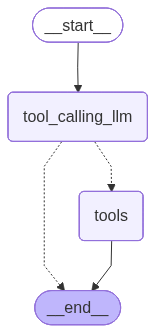

In [17]:
## Stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state['messages'])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", END)
graph = builder.compile()

from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
response = graph.invoke({"messages": "What is the recent news around AI"})

In [19]:
response['messages'][-1].content

'{"query": "recent artificial intelligence AI news developments 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest News | Insights Powering AI-Driven Business Growth", "content": "US and Japan announce sweeping AI and tech collaboration · Artificial Intelligence. April 11, 2024. UK and Canada sign AI compute agreement · Artificial", "score": 0.81133276, "raw_content": null}, {"title": "Latest AI Research Developments 2024 | Restackio", "url": "https://store-restack.vercel.app/p/ai-development-trends-predictions-answer-latest-ai-research-developments-2024", "content": "## Accelerate with a custom POC\\n\\nForward-deployed engineers, tailored integrations, enterprise support.\\n\\n## Footer\\n\\nDesign, Test and Optimize Agents at Enterprise Scale\\n\\n### Product\\n\\n### Resources\\n\\n### Cloud\\n\\n### About\\n\\nPrivacyTerms [...] ## Enterprise-grade tracing for AI agents\\n

In [20]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent news around AI
================================== Ai Message ==================================

I'll search for recent news about artificial intelligence to give you an up-to-date overview.
Tool Calls:
  tavily_search (call_00_Rq3vTS5lYLTRpzBgCsmdZaIi)
 Call ID: call_00_Rq3vTS5lYLTRpzBgCsmdZaIi
  Args:
    query: recent artificial intelligence AI news developments 2024
    search_depth: advanced
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent artificial intelligence AI news developments 2024", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest News | Insights Powering AI-Driven Business Growth", "content": "US and Japan announce sweeping AI and tech collaboration · Artificial Intelligence. Apr

In [21]:
response2 = graph.invoke({'messages' : "what will be 38 multiply by 72"})
for m2 in response2['messages']:
    m2.pretty_print()

================================ Human Message =================================

what will be 38 multiply by 72
================================== Ai Message ==================================

I can help you calculate 38 multiplied by 72. Let me use the multiplication tool for you.
Tool Calls:
  multiply (call_00_k11PPZ32CxyLXRMDsBwZV9VY)
 Call ID: call_00_k11PPZ32CxyLXRMDsBwZV9VY
  Args:
    a: 38
    b: 72
================================= Tool Message =================================
Name: multiply

2736


In [22]:
response3 = graph.invoke({'messages' : "Give me the recent AI news and then multiply 5 by 10"})
for m3 in response3['messages']:
    m3.pretty_print()

================================ Human Message =================================

Give me the recent AI news and then multiply 5 by 10
================================== Ai Message ==================================

I'll help you with both tasks. First, let me get the recent AI news, and then I'll multiply 5 by 10.
Tool Calls:
  tavily_search (call_00_f2pEzAuFp8iZbvALJlUbWjH2)
 Call ID: call_00_f2pEzAuFp8iZbvALJlUbWjH2
  Args:
    query: recent AI news 2024 artificial intelligence developments
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news 2024 artificial intelligence developments", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://time.com/7339685/person-of-the-year-2025-ai-architects/", "title": "The Architects of AI Are TIME’s 2025 Person of the Year - Time Magazine", "score": 0.61363083, "published_da

### React Agent Architecture

In [64]:
## Stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

## node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state['messages'])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile()

response3 = graph.invoke({'messages' : "Give me the recent AI news and then multiply 5 by 10"})
for m3 in response3['messages']:
    m3.pretty_print()

================================ Human Message =================================

Give me the recent AI news and then multiply 5 by 10
================================== Ai Message ==================================

I'll help you with both requests. First, let me get the recent AI news, and then I'll perform the multiplication.
Tool Calls:
  tavily_search (call_00_Ysu0CI1uPLeXQ31NCjGE53tV)
 Call ID: call_00_Ysu0CI1uPLeXQ31NCjGE53tV
  Args:
    query: recent AI news 2024 artificial intelligence developments
    search_depth: advanced
    time_range: week
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news 2024 artificial intelligence developments", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.startupecosystem.ca/news/openai-unveils-gpt-5-2-amidst-competitive-ai-landscape/", "title": "OpenAI Unveils GPT-5.2 Amidst Competitive AI Landscape - Startup E

### Adding memory in Agentic Graph

In [28]:
response = graph.invoke({'messages' : "Hello My name is alex alexandar nice to meet u"})
for m3 in response['messages']:
    m3.pretty_print()

================================ Human Message =================================

Hello My name is alex alexandar nice to meet u
================================== Ai Message ==================================

Hello Alex Alexander! Nice to meet you too! 😊

How can I help you today? I have access to a search engine for finding information and a simple multiplication tool. Is there something specific you'd like to know about or need assistance with?


In [29]:
response = graph.invoke({'messages' : "Tell me what is my name"})
for m3 in response['messages']:
    m3.pretty_print()

================================ Human Message =================================

Tell me what is my name
================================== Ai Message ==================================

I don't have access to personal information about you, including your name. To help you with this, I would need you to tell me your name directly. Once you share that information with me, I'll be happy to address you by name in our conversation!


In [35]:
## Stategraph
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## node definition
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tool.invoke(state['messages'])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile(checkpointer=memory)

In [36]:
config = {"configurable": {"thread_id": "1"}}
response = graph.invoke({'messages': "Hi my name is Alex"}, config=config)
response

{'messages': [HumanMessage(content='Hi my name is Alex', additional_kwargs={}, response_metadata={}, id='3b9fef00-cf22-4ae8-87d3-4c3e4c2b527c'),
  AIMessage(content='Hi Alex! Nice to meet you. How can I help you today? I have access to a search engine for finding current information and can also perform calculations if you need any mathematical help.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1869, 'total_tokens': 1907, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 1856}, 'prompt_cache_hit_tokens': 1856, 'prompt_cache_miss_tokens': 13}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'e3095112-e993-4a23-9e1c-6bd3f506b698', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2d98-e3e9-7103-9c84-90ba4c3a04fc-0', usage_metadata={'input_tokens': 1869, 'output_tokens': 38, 'total_

In [37]:
response['messages'][-1].content

'Hi Alex! Nice to meet you. How can I help you today? I have access to a search engine for finding current information and can also perform calculations if you need any mathematical help.'

In [38]:
response = graph.invoke({'messages': "hey what is my name"}, config=config)
response['messages'][-1].content

"You told me your name is Alex! Nice to meet you, Alex. Is there anything specific you'd like help with today?"

In [39]:
response = graph.invoke({'messages': "hey do you even remember my my name"}, config=config)
response['messages'][-1].content

"Yes, I remember your name is Alex! You introduced yourself at the beginning of our conversation. Is there something specific you'd like to discuss or ask about, Alex?"

### Streaming

In [45]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [46]:
def superbot(state: State):
    return {'messages': [llm.invoke(state['messages'])]}

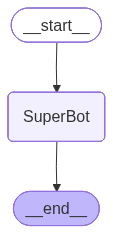

In [60]:
graph = StateGraph(State)
graph.add_node("SuperBot", superbot)
graph.add_edge(START, "SuperBot")
graph.add_edge("SuperBot", END)
graph_builder = graph.compile(checkpointer=memory)

from IPython.display import display, Image
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [67]:
## Invocation 

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages': "Hi, My name is Sushant and I like cricket"}, config)

{'messages': [HumanMessage(content='Hi, My name is Sushant and I like cricket', additional_kwargs={}, response_metadata={}, id='ef866c99-9dd1-444f-b0f4-715dcec9abda'),
  AIMessage(content='Nice to meet you, Sushant! Cricket is a fantastic sport—full of strategy, skill, and excitement. Do you have a favorite team or player? Or do you play cricket yourself? 🏏', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 43, 'prompt_tokens': 16, 'total_tokens': 59, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 16}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '98309a59-4bc0-416f-97de-0101421f0efa', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2da7-faf5-7451-910d-bd1ded13a027-0', usage_metadata={'input_tokens': 16, 'output_tokens': 43, 'total_token

In [70]:
# .stream() and .astream() for sync and async methods for streaming back results  (values, updates)
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages': "Hi, My name is Sushant and I like cricket"}, config, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Sushant! 😊\n\nIt's great to meet you — and awesome that you love cricket! It’s such an exciting sport, whether you're watching or playing.\n\nSince you mentioned it twice, I’m guessing cricket is a big part of your life!  \nAre you a fan of a particular team or player? Or do you play yourself — maybe in a local club, with friends, or even just in the backyard?\n\nLet’s talk cricket! 🏏⚾😄", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 226, 'total_tokens': 329, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 192}, 'prompt_cache_hit_tokens': 192, 'prompt_cache_miss_tokens': 34}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'f8cb1ed4-b219-425c-bcf1-36afcdd7b953', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2dae-307a-7703-b389-

In [71]:
# .stream() and .astream() for sync and async methods for streaming back results  (values, updates)
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages': "Hi, My name is Sushant and I like cricket"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Sushant and I like cricket', additional_kwargs={}, response_metadata={}, id='a3cb8726-4d90-4121-b431-258107f3511d'), AIMessage(content='Nice to meet you, Sushant! Cricket is a fantastic sport—full of strategy, skill, and excitement. Do you have a favorite team or player? Are you more into playing, watching, or both? 😊🏏', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 16, 'total_tokens': 64, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 16}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'e156fe0e-fe5b-4877-a860-6456c31e3dfa', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2dad-2fd3-7801-b3b3-8588a8b63a03-0', usage_metadata={'input_tokens': 16, 'output_tokens': 48, 

In [72]:
# .stream() and .astream() for sync and async methods for streaming back results  (values, updates)
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages': "Hi, My name is Abiskar and I like batminton"}, config, stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Abiskar! It's nice to meet you. Badminton is a fantastic sport—it's fast, fun, and great for fitness. Do you play often, or do you enjoy watching matches too?  \n\nIf you ever want to talk about badminton tips, favorite players, or anything else, feel free to chat! 😊🏸", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 17, 'total_tokens': 88, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 17}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '2ee1f3e2-086e-4b6b-9525-99120000f783', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2daf-52d4-7fe1-b59f-963e867de676-0', usage_metadata={'input_tokens': 17, 'output_tokens': 71, 'total_tokens': 88, 'input_token_details': {'cache_rea

In [73]:
for chunk in graph_builder.stream({'messages': "I also like football"}, config, stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, My name is Abiskar and I like batminton', additional_kwargs={}, response_metadata={}, id='3ad536d5-70b7-4a3d-b69e-35315c225530'), AIMessage(content="Hi Abiskar! It's nice to meet you. Badminton is a fantastic sport—it's fast, fun, and great for fitness. Do you play often, or do you enjoy watching matches too?  \n\nIf you ever want to talk about badminton tips, favorite players, or anything else, feel free to chat! 😊🏸", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 17, 'total_tokens': 88, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 17}, 'model_provider': 'deepseek', 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': '2ee1f3e2-086e-4b6b-9525-99120000f783', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019b2daf-

In [75]:
config = {"configurable": {"thread_id": "5"}}

async for chunk in graph_builder.astream_events({'messages': "Hi, My name is Abiskar and I like batminton"}, config, version="v2"):
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'messages': 'Hi, My name is Abiskar and I like batminton'}}, 'name': 'LangGraph', 'tags': [], 'run_id': '019b2db2-6169-7c81-92f1-633a787bb6c7', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, My name is Abiskar and I like batminton', additional_kwargs={}, response_metadata={}, id='9088c7fa-db9a-44b5-bc3b-76537efa64e5')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': '019b2db2-6189-7783-aac0-fbf36f606962', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:00868235-ffd7-fec0-a2f9-20c8df70a7c7'}, 'parent_ids': ['019b2db2-6169-7c81-92f1-633a787bb6c7']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, My name is Abiskar and I like batminton',